In [243]:
import pandas as pd
from datetime import datetime
import json

# Data Cleaning Overview

## CSV Data

By analyzing the data, I found that there were many rows (~500,000) where the 'PLAYERID' column had almost entirely another row of data. In order to fix this, I dropped the corrupted data (rows with *extra* columns) only. I later worked on the rows with additional information in them later. 

I ended up with ~700,000 clean rows of data, and 500,000 corrupted rows, but those 500,000 became about 1,000,000 after cleaning in Excel. After concatenating them all, I ended up with ~1.7 million. Of these 1.7 million there were still a few thousand rows of data that were corrupted, but because they made up such a small portion of the data, I dropped them. Some examples of these types of these left over corrupted rows are values that should've been in the "MAP" column in the "CHARACTER" column, and some also in the "EVENT" column. I used Regex to find these incorrect values. 

I also changed the datatypes to be int or string where applicable. 

# JSON data

The data in the JSON was a one-to-many relationship. Each JSON blob had 1 "context" field, and 1 or more "weapons" fields. In order to work with this in a pandas dataframe, I added a "unique_id" field to each JSON blob, so that if I wanted to rejoin the weapons and the context tables, I could do so with that column (there was no unique identifier in the "context" field). 

This data was already clean when I imported it. I just had to get it into a CSV instead of a JSON. 

The result was two tables. One with all of the context data and one with the weapons data, both having a column of the "unique_id" so that they can be rejoined later. 

In [400]:
# df1 = pd.read_csv('analytics.csv', error_bad_lines=False)
df1.to_csv('analytics_dropped.csv')

In [398]:
df1 = pd.read_csv('analytics_dropped.csv')

In [399]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1241349 entries, 0 to 1241348
Data columns (total 10 columns):
Unnamed: 0    1241349 non-null int64
Unnamed: 1    1241349 non-null int64
DATE          1241349 non-null object
PLAYERID      1241349 non-null object
PLATFORM      1235850 non-null object
CHARACTER     1235833 non-null object
MAP           1235834 non-null object
EVENT         1235834 non-null object
PLAYEDTIME    1233936 non-null float64
LEVEL         139557 non-null float64
dtypes: float64(2), int64(2), object(6)
memory usage: 94.7+ MB


Slicing for the rows with extra information in the PLAYERID columns

In [396]:
df1[df1['PLAYERID'].str.contains(',')]

DATE                                           PLAYERID  \
2023 11  20 18:00:00  000019b435911a2c74c499fcbc739a01,3,BPChar_Beas...   
     10  11 19:00:00  00003c6bb1dd994663e3b1a92a04d8a0,3,BPChar_Gunn...   
     10  18 19:00:00  000033b91707994ae2eab63ed7bf5f24,2,BPChar_Sire...   
     11  17 18:00:00  0000431a3f19bb896d3d82a33c7a208f,2,BPChar_Gunn...   
     11  13 18:00:00  0000466dd39896eae8fc0e068175696f,1,BPChar_Oper...   
...              ...                                                ...   
     11  20 18:00:00  00002a7829c143184a455477804ac143,3,BPChar_Beas...   
     10  29 19:00:00  00000f66dec0e799fe8e10b5e00b672f,3,BPChar_Sire...   
     10  10 19:00:00  000018a507f922d9b484239d48de7a8b,2,BPChar_Beas...   
     10  29 19:00:00  00002f5845c7ba6351305a74e1a0bf1e,2,BPChar_Oper...   
     10  26 19:00:00  00003bf5678a259e3b5aaf2fc5f89ebf,2,BPChar_Gunn...   

        PLATFORM             CHARACTER              MAP    EVENT  PLAYEDTIME  \
2023 11        3    BPChar_Operative_C      Monastery_P  LevelUp     17198.0   
     10        3        BPChar_Siren_C           Loader  LevelUp     75408.0   
     10        2    BPChar_Operative_C      Monastery_P  LevelUp    201201.0   
     11        2    BPChar_Operative_C       Prologue_P  LevelUp     12370.0   
     11        1  BPChar_Beastmaster_C   COVSlaughter_P  LevelUp     90574.0   
...          ...                   ...              ...      ...         ...   
     11        3  BPChar_Beastmaster_C       Wetlands_P  LevelUp     51845.0   
     10        3       BPChar_Gunner_C        AtlasHQ_P  LevelUp     21539.0   
     10        2        BPChar_Siren_C          Beach_P  LevelUp    290393.0   
     10        2    BPChar_Operative_C  WetlandsVault_P  LevelUp     56697.0   
     10        2     BPChar_IronBear_C      Sacrifice_P  LevelUp      6333.0   

         LEVEL  
2023 11    NaN  
     10    NaN  
     10    NaN  
     11    NaN  
     11    NaN  
...        ...  
     11    NaN  
     10    NaN  
     10    NaN  
     10    NaN  
     10    NaN  

[508986 rows x 8 columns]

~500,000 rows with extra data

In [189]:
len(df1[df1['PLAYERID'].str.contains(',')])

508986

Separating the clean data from the corrupted data.

In [8]:
no_errors = df1[~df1['PLAYERID'].str.contains(',')]

In [9]:
no_errors

DATE                          PLAYERID PLATFORM  \
2023 10  25 19:00:00  00001acbf8c3f062e675acff49a4bc04        2   
     10  09 19:00:00  00000a3164b82084ae789049fc017d69        3   
     10  13 19:00:00  000039c73d105e3ee64c972d95940cd0        3   
     10  14 19:00:00  00003a8cacb62ea7659fe5e6ee7795a8        3   
     10  15 19:00:00  00000a5be05326fac47d729e90de04ac        3   
...              ...                               ...      ...   
2024 1   22 18:00:00  00002334b514baf2f1770078786a26a8        1   
     1   22 18:00:00  00001b8c5ed90905190d9d355fc09c60        1   
     1   22 18:00:00  0000436f5576dd5a2507a1c48e43e1d0        1   
     1   23 18:00:00  000041c68dfa01a5045c64ebc339e4f5        1   
     1   23 18:00:00  000006caf35726850ec0f11339b4f88c        1   

                           CHARACTER                  MAP    EVENT  \
2023 10           BPChar_Operative_C          Outskirts_P  LevelUp   
     10               BPChar_Siren_C  CreatureSlaughter_P  LevelUp   
     10               BPChar_Siren_C           Wetlands_P  LevelUp   
     10               BPChar_Siren_C             Prison_P  LevelUp   
     10               BPChar_Siren_C          Monastery_P  LevelUp   
...                              ...                  ...      ...   
2024 1          BPChar_Beastmaster_C           Wetlands_P  LevelUp   
     1   BPChar_IronBear_DakkaBear_C          Motorcade_P  LevelUp   
     1                BPChar_Siren_C         Sanctuary3_P  LevelUp   
     1          BPChar_Beastmaster_C             Towers_P  LevelUp   
     1                BPChar_Siren_C             Prison_P  LevelUp   

         PLAYEDTIME  LEVEL  
2023 10     16563.0    NaN  
     10     30601.0    NaN  
     10     44831.0    NaN  
     10     65665.0    NaN  
     10     16128.0    NaN  
...             ...    ...  
2024 1      68096.0   27.0  
     1     108595.0   37.0  
     1      49557.0   18.0  
     1      92478.0    NaN  
     1     105439.0   50.0  

[732363 rows x 8 columns]

In [10]:
no_errors['PLAYEDTIME'] = no_errors['PLAYEDTIME'].astype(int)


C:\Users\miste\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
no_errors.reset_index(inplace = True)

Resetting index and renaming to YEAR and MONTH respectively, so that I can stack on to the cleaned corrupted data.

In [12]:
no_errors.rename({'level_0':'YEAR','level_1':'MONTH','DATE':'DAY'}, axis = 1, inplace = True)

C:\Users\miste\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [13]:
no_errors.head()

,YEAR,MONTH,DAY,PLAYERID,PLATFORM,CHARACTER,MAP,EVENT,PLAYEDTIME,LEVEL
0,2023,10,25 19:00:00,00001acbf8c3f062e675acff49a4bc04,2,BPChar_Operative_C,Outskirts_P,LevelUp,16563,NaN
1,2023,10,09 19:00:00,00000a3164b82084ae789049fc017d69,3,BPChar_Siren_C,CreatureSlaughter_P,LevelUp,30601,NaN
2,2023,10,13 19:00:00,000039c73d105e3ee64c972d95940cd0,3,BPChar_Siren_C,Wetlands_P,LevelUp,44831,NaN
3,2023,10,14 19:00:00,00003a8cacb62ea7659fe5e6ee7795a8,3,BPChar_Siren_C,Prison_P,LevelUp,65665,NaN
4,2023,10,15 19:00:00,00000a5be05326fac47d729e90de04ac,3,BPChar_Siren_C,Monastery_P,LevelUp,16128,NaN


Extracting data to work and clean in excel

In [14]:
# delimeters = df[df['PLAYERID'].str.contains(',')]

In [15]:
# delimeters.to_csv('commas.csv')

Importing cleaned data.

Since PLAYERID contained almost an entirely separate entry of data, I split it by commas, and kept both rows within the same table, except the first row's columns have 1 at the end, and the second row's columns have a 2. These will be separated now in Pandas. 

In [16]:
df2 = pd.read_csv('commas.csv', error_bad_lines=False)


In [17]:
df2

,YEAR1,MONTH1,DAY1,PLAYERID1,PLATFORM1,CHARACTER,MAP,EVENT1,PLAYEDTIME,LEVEL,YEAR2,MONTH2,DAY2,PLAYERID2,PLATFORM2,CHARACTER2,MAP2,EVENT2,PLAYEDTIME2,LEVEL2
0,2023,11,20 18:00:00,000019b435911a2c74c499fcbc739a01,3,BPChar_Beastmaster_C,Prologue_P,LevelUp,7866,0,2023.0,11.0,22 18:00:00,000002d0c1df3e77128921da89a5d655,3,BPChar_Operative_C,Monastery_P,LevelUp,17198.0,NaN
1,2023,10,11 19:00:00,00003c6bb1dd994663e3b1a92a04d8a0,3,BPChar_Gunner_C,AtlasHQ_P,LevelUp,28691,0,2023.0,11.0,21 18:00:00,00002b8968bac2feb81eabf0a509642b,3,BPChar_Siren_C,Loader,LevelUp,75408.0,NaN
2,2023,10,18 19:00:00,000033b91707994ae2eab63ed7bf5f24,2,BPChar_Siren_C,ProvingGrounds_Trial4_P,LevelUp,178546,0,2023.0,10.0,12 19:00:00,0000234277ff548a5e009ab7467121b6,2,BPChar_Operative_C,Monastery_P,LevelUp,201201.0,NaN
3,2023,11,17 18:00:00,0000431a3f19bb896d3d82a33c7a208f,2,BPChar_Gunner_C,COVSlaughter_P,LevelUp,61067,0,2023.0,10.0,12 19:00:00,0000363f80d92a54ca6ceddffdad1596,2,BPChar_Operative_C,Prologue_P,LevelUp,12370.0,NaN
4,2023,11,13 18:00:00,0000466dd39896eae8fc0e068175696f,1,BPChar_Operative_C,COVSlaughter_P,LevelUp,400079,0,2023.0,11.0,14 18:00:00,000008c14c4583855dafe14734370de8,1,BPChar_Beastmaster_C,COVSlaughter_P,LevelUp,90574.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508981,2023,11,20 18:00:00,00002a7829c143184a455477804ac143,3,BPChar_Beastmaster_C,Wetlands_P,LevelUp,43509,0,2023.0,10.0,16 19:00:00,00002b83417861ca082d9428bd451c8e,3,BPChar_Beastmaster_C,Wetlands_P,LevelUp,51845.0,NaN
508982,2023,10,29 19:00:00,00000f66dec0e799fe8e10b5e00b672f,3,BPChar_Siren_C,Mine_P,LevelUp,134518,0,2023.0,10.0,28 19:00:00,0000275cb642f7995231e6ec8471d172,3,BPChar_Gunner_C,AtlasHQ_P,LevelUp,21539.0,NaN
508983,2023,10,10 19:00:00,000018a507f922d9b484239d48de7a8b,2,BPChar_Beastmaster_C,Sanctuary3_P,LevelUp,81907,0,2023.0,10.0,29 19:00:00,0000341cba6a47177ae9c8fac1ba25c5,2,BPChar_Siren_C,Beach_P,LevelUp,290393.0,NaN
508984,2023,10,29 19:00:00,00002f5845c7ba6351305a74e1a0bf1e,2,BPChar_Operative_C,Loader,LevelUp,7523,0,2023.0,10.0,30 19:00:00,0000164d36faf4251c516dcce034b769,2,BPChar_Operative_C,WetlandsVault_P,LevelUp,56697.0,NaN


Splitting the dataframe with 2 sets of data and renaming to be consistent with the clean dataset from above. At the end of this, I will have 3 dataframes with the same columns that I can then merge together. 

In [208]:
df21 = df2[['YEAR1','MONTH1','DAY1','PLAYERID1','PLATFORM1','CHARACTER','MAP','EVENT1','PLAYEDTIME','LEVEL']]

In [209]:
df21.rename({'YEAR1':'YEAR', 'MONTH1':'MONTH','DAY1':'DAY','PLAYERID1':'PLAYERID','PLATFORM1':'PLATFORM','CHARACTER1':'CHARACTER',\
            'MAP1':'MAP','EVENT1':'EVENT','PLAYEDTIME1':'PLAYEDTIME','LEVEL1':'LEVEL'}, axis = 1, inplace = True)

In [210]:
df21['YEAR'] = df21['YEAR'].astype(str)
df21['MONTH'] = df21['MONTH'].astype(str)
df21['DAY'] = df21['DAY'].astype(str)

C:\Users\miste\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\miste\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\miste\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [195]:
df21.reset_index(inplace = True)

In [196]:
df21.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508986 entries, 0 to 508985
Data columns (total 11 columns):
index         508986 non-null int64
YEAR          508986 non-null object
MONTH         508986 non-null object
DAY           508986 non-null object
PLAYERID      508986 non-null object
PLATFORM      508986 non-null int64
CHARACTER     508986 non-null object
MAP           508986 non-null object
EVENT         508986 non-null object
PLAYEDTIME    508986 non-null int64
LEVEL         508986 non-null int64
dtypes: int64(4), object(7)
memory usage: 42.7+ MB


In [197]:
df21.YEAR.unique()

array(['2023', '2024'], dtype=object)

In [211]:
df22 = df2[['YEAR2','MONTH2','DAY2','PLAYERID2','PLATFORM2','CHARACTER2','MAP2','EVENT2','PLAYEDTIME2','LEVEL2']]

In [212]:
df22.rename({'YEAR2':'YEAR', 'MONTH2':'MONTH','DAY2':'DAY','PLAYERID2':'PLAYERID','PLATFORM2':'PLATFORM','CHARACTER2':'CHARACTER',\
            'MAP2':'MAP','EVENT2':'EVENT','PLAYEDTIME2':'PLAYEDTIME','LEVEL2':'LEVEL'}, axis = 1, inplace = True)

In [213]:
df22['YEAR'] = df22['YEAR'].astype(object)
df22['MONTH'] = df22['MONTH'].astype(object)

C:\Users\miste\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\miste\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [214]:
df22.head()

,YEAR,MONTH,DAY,PLAYERID,PLATFORM,CHARACTER,MAP,EVENT,PLAYEDTIME,LEVEL
0,2023,11,22 18:00:00,000002d0c1df3e77128921da89a5d655,3,BPChar_Operative_C,Monastery_P,LevelUp,17198.0,NaN
1,2023,11,21 18:00:00,00002b8968bac2feb81eabf0a509642b,3,BPChar_Siren_C,Loader,LevelUp,75408.0,NaN
2,2023,10,12 19:00:00,0000234277ff548a5e009ab7467121b6,2,BPChar_Operative_C,Monastery_P,LevelUp,201201.0,NaN
3,2023,10,12 19:00:00,0000363f80d92a54ca6ceddffdad1596,2,BPChar_Operative_C,Prologue_P,LevelUp,12370.0,NaN
4,2023,11,14 18:00:00,000008c14c4583855dafe14734370de8,1,BPChar_Beastmaster_C,COVSlaughter_P,LevelUp,90574.0,NaN


In [215]:
df22.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 508986 entries, 0 to 508985
Data columns (total 10 columns):
YEAR          502044 non-null object
MONTH         501388 non-null object
DAY           501388 non-null object
PLAYERID      501388 non-null object
PLATFORM      503487 non-null object
CHARACTER     503471 non-null object
MAP           503471 non-null object
EVENT         503471 non-null object
PLAYEDTIME    501573 non-null float64
LEVEL         54821 non-null float64
dtypes: float64(2), object(8)
memory usage: 38.8+ MB


Here I spotted that there were still a few corrupted rows. The YEAR column should only have 2023 and 2024

In [216]:
df22.YEAR.unique()

array([2023.0, nan, 2024.0, 50.0, 38.0, 9.0, 26.0, 7.0, 19.0, 5.0, 8.0,
       32.0, 29.0, 36.0, 4.0, 25.0, 33.0, 2.0, 45.0, 40.0, 11.0, 44.0,
       12.0, 23.0, 10.0, 31.0, 43.0, 14.0, 30.0, 39.0, 28.0, 3.0, 24.0,
       6.0, 15.0, 27.0, 22.0, 18.0, 46.0, 20.0, 21.0, 41.0, 1.0, 42.0,
       35.0, 13.0, 34.0, 49.0, 37.0, 47.0, 17.0, 48.0, 16.0], dtype=object)

Only 656 out of 1.7 million. I will drop these

In [217]:
len(df22[df22['YEAR'] < 2000])

656

Platform should be 1-5, and there are many characters and maps in this row.

In [37]:
df22.PLATFORM.unique()

array(['3', '2', '1', 'BPChar_Gunner_C', nan, 'BPChar_IronBear_C',
       'BPChar_Beastmaster_C', 'BPChar_Operative_C', 'NONE',
       'BPChar_Siren_C', 'BPChar_IronBear_DakkaBear_C',
       '2,BPChar_Beastmaster_C,ProvingGrounds_Trial6_P,LevelUp,109200,',
       '4', 'Vehicle_Outrunner_C', '5',
       '1,NONE,Monastery_P,LevelUp,41900,',
       'Vehicle_Revolver_HoverWheels_C', 'Vehicle_Technical_C',
       '3,BPChar_Operative_C,Loader,LevelUp,143500,43',
       '3,BPChar_Gunner_C,Crypt_P,LevelUp,290600,',
       '1,BPChar_Operative_C,Monastery_P,LevelUp,87400,42',
       '1,BPChar_Siren_C,Prologue_P,LevelUp,2900,', 'IO_GroundTurret_C',
       '1,BPChar_Operative_C,OrbitalPlatform_P,LevelUp,22400,',
       '3,BPChar_Siren_C,Mansion_P,LevelUp,31600,',
       'Vehicle_GunnerSeat_Outrunner_C',
       '1,BPChar_Gunner_C,City_P,LevelUp,89400,',
       'Vehicle_Outrunner_ZipWheels_C',
       '1,BPChar_Siren_C,COVSlaughter_P,LevelUp,172000,',
       'Vehicle_Technical_HoverWheels_C', 'Vehicl

Just like for YEAR, there are not too many corrupted entries. Only 7,600 out of 500,000 (in this specific dataframe), which is 1.5% of the data and 0.4% of the total data. So I will also drop these rows

In [221]:
len(df22[~df22['PLATFORM'].isin([1,2,3,4,5,'1','2','3','4','5'])])

7614

Making sure that YEAR and PLATFORM have certain entries only

In [222]:
df22_clean = df22[(df22['YEAR'] > 2000) & (df22['PLATFORM'].isin([1,2,3,4,5,'1','2','3','4','5']))]

In [223]:
len(df22_clean)

501372

Concatenating the 3 dataframes

In [224]:
full_data = pd.concat([no_errors, df21, df22_clean], axis = 0)

In [225]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1742721 entries, 0 to 508985
Data columns (total 10 columns):
YEAR          object
MONTH         object
DAY           object
PLAYERID      object
PLATFORM      object
CHARACTER     object
MAP           object
EVENT         object
PLAYEDTIME    float64
LEVEL         float64
dtypes: float64(2), object(8)
memory usage: 146.3+ MB


There's 1 instance where character is null. I'll drop this

In [227]:
len(full_data[full_data['CHARACTER'].isnull()])

1

In [228]:
full_data.dropna(inplace = True, subset = ['CHARACTER'])

There are ~2,000 rows where the CHARACTER row is missing, and the rows to the right of that column were shifted over. I will drop these by making sure that the CHARACTER column does not end in P (assuming that all Characters end with _C)

In [231]:
full_data[full_data['CHARACTER'].str.endswith('P')]

,YEAR,MONTH,DAY,PLAYERID,PLATFORM,CHARACTER,MAP,EVENT,PLAYEDTIME,LEVEL
32,2023,10,17 19:00:00,0000034158dcd70597f4a0008b1be500,1,ProvingGrounds_Trial4_P,LevelUp,1569,0.0,0.0
506,2023,11,30 18:00:00,00002ee7d0568a59648be1608ab45a00,1,Sacrifice_P,LevelUp,3229,0.0,0.0
745,2023,10,08 19:00:00,000008470b95da15291508ea98dd8b00,2,Sacrifice_P,LevelUp,8013,0.0,0.0
946,2023,10,23 19:00:00,0000282be554b69be9349240da954900,3,Mine_P,LevelUp,349128,0.0,0.0
1526,2023,10,31 19:00:00,000004049466da527a24f9dbfdcd8f00,1,Sacrifice_P,LevelUp,4828,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
507337,2023,10,11 19:00:00,00000aa15e5814723ffeabee2e94a700,2,MotorcadeInterior_P,LevelUp,82480,0.0,0.0
507928,2023,10,27 19:00:00,00000c23419a28de43eaece9c0199400,2,OrbitalPlatform_P,LevelUp,25490,0.0,0.0
508652,2023,11,27 18:00:00,00003dd1478f2de6ac28917cafe83500,1,COVSlaughter_P,LevelUp,829729,0.0,0.0
508877,2023,10,09 19:00:00,00000aa15e5814723ffeabee2e94a700,2,Towers_P,LevelUp,25947,0.0,0.0


In [232]:
full_data = full_data[~full_data['CHARACTER'].str.endswith('P')]

After dropping those, there are still a few remaining that are shifted. I will drop these by making sure the EVENT column equals LevelUp

In [234]:
full_data[full_data['EVENT'] != 'LevelUp']

,YEAR,MONTH,DAY,PLAYERID,PLATFORM,CHARACTER,MAP,EVENT,PLAYEDTIME,LEVEL
1422,2023,10,11 19:00:00,0000242a311a747b6108945f7d160600,1,Loader,LevelUp,79196,0.0,0.0
1466,2023,10,23 19:00:00,00000a93bab022c05206f1d904ec7800,2,Loader,LevelUp,116274,0.0,0.0
4792,2023,10,09 19:00:00,0000147b551a9a078da1577295194c00,3,Loader,LevelUp,36310,0.0,0.0
6817,2023,10,17 19:00:00,000008470b95da15291508ea98dd8b00,2,Loader,LevelUp,11480,0.0,0.0
7501,2023,10,12 19:00:00,00001c3780b790f8cd8fe5dd8dae6800,3,Loader,LevelUp,26851,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
493253,2023,10,24 19:00:00,00002acd5c3dc8db9ff93c4496657d00,2,Loader,LevelUp,66070,0.0,0.0
494039,2023,11,06 18:00:00,000025651e84954ba69530789fad9600,1,Loader,LevelUp,113457,0.0,0.0
503636,2023,11,02 19:00:00,0000014b04897d6bb3e342d535a8b200,2,Loader,LevelUp,140638,0.0,0.0
506365,2023,10,15 19:00:00,00003dd1478f2de6ac28917cafe83500,1,Loader,LevelUp,47417,0.0,0.0


In [235]:
full_data = full_data[full_data['EVENT'] == 'LevelUp']

In [236]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1740621 entries, 0 to 508985
Data columns (total 10 columns):
YEAR          object
MONTH         object
DAY           object
PLAYERID      object
PLATFORM      object
CHARACTER     object
MAP           object
EVENT         object
PLAYEDTIME    float64
LEVEL         float64
dtypes: float64(2), object(8)
memory usage: 146.1+ MB


There seems to be one outlier in the LEVEL column. This should only reach 50, but there is one that is very high. I'll drop this one

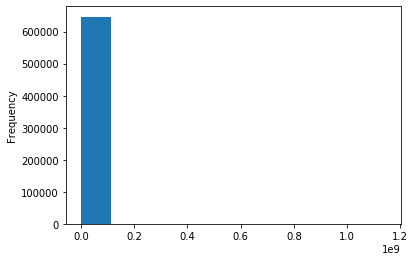

In [237]:
full_data.LEVEL.plot(kind = 'hist')

Not all rows have an entry, so I need to keep the NULL values as well. 

In [238]:
full_data = full_data[(full_data['LEVEL'] < 100) | (full_data['LEVEL'].isnull())]

In [239]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1740618 entries, 0 to 508985
Data columns (total 10 columns):
YEAR          object
MONTH         object
DAY           object
PLAYERID      object
PLATFORM      object
CHARACTER     object
MAP           object
EVENT         object
PLAYEDTIME    float64
LEVEL         float64
dtypes: float64(2), object(8)
memory usage: 146.1+ MB


Changing the types so that I can work with them

In [240]:
full_data['YEAR'] = full_data['YEAR'].astype(int)
full_data['MONTH'] = full_data['MONTH'].astype(int)
full_data['PLAYERID'] = full_data['PLAYERID'].astype(str)
full_data['PLATFORM'] = full_data['PLATFORM'].astype(int)
full_data['PLAYEDTIME'] = full_data['PLAYEDTIME'].astype(int)


In [241]:
full_data.set_index(['YEAR','MONTH'])

DAY                          PLAYERID  PLATFORM  \
YEAR MONTH                                                            
2023 10     25 19:00:00  00001acbf8c3f062e675acff49a4bc04         2   
     10     09 19:00:00  00000a3164b82084ae789049fc017d69         3   
     10     13 19:00:00  000039c73d105e3ee64c972d95940cd0         3   
     10     14 19:00:00  00003a8cacb62ea7659fe5e6ee7795a8         3   
     10     15 19:00:00  00000a5be05326fac47d729e90de04ac         3   
...                 ...                               ...       ...   
     10     16 19:00:00  00002b83417861ca082d9428bd451c8e         3   
     10     28 19:00:00  0000275cb642f7995231e6ec8471d172         3   
     10     29 19:00:00  0000341cba6a47177ae9c8fac1ba25c5         2   
     10     30 19:00:00  0000164d36faf4251c516dcce034b769         2   
     10     25 19:00:00  0000076b7112e884ae0d294939d844d2         2   

                       CHARACTER                  MAP    EVENT  PLAYEDTIME  \
YEAR MONTH                                                                   
2023 10       BPChar_Operative_C          Outskirts_P  LevelUp       16563   
     10           BPChar_Siren_C  CreatureSlaughter_P  LevelUp       30601   
     10           BPChar_Siren_C           Wetlands_P  LevelUp       44831   
     10           BPChar_Siren_C             Prison_P  LevelUp       65665   
     10           BPChar_Siren_C          Monastery_P  LevelUp       16128   
...                          ...                  ...      ...         ...   
     10     BPChar_Beastmaster_C           Wetlands_P  LevelUp       51845   
     10          BPChar_Gunner_C            AtlasHQ_P  LevelUp       21539   
     10           BPChar_Siren_C              Beach_P  LevelUp      290393   
     10       BPChar_Operative_C      WetlandsVault_P  LevelUp       56697   
     10        BPChar_IronBear_C          Sacrifice_P  LevelUp        6333   

            LEVEL  
YEAR MONTH         
2023 10       NaN  
     10       NaN  
     10       NaN  
     10       NaN  
     10       NaN  
...           ...  
     10       NaN  
     10       NaN  
     10       NaN  
     10       NaN  
     10       NaN  

[1740618 rows x 8 columns]

In [242]:
full_data['DAY_NUM'] = full_data['DAY'].str.slice(stop = 2)
full_data['TIME'] = full_data['DAY'].str.slice(start = 2)


In [395]:
full_data.to_csv('full_data.csv', index = False)

In [341]:
import numpy as np

## Here I will be importing the data from the JSON file

Opening and reading the json file into a list of strings

In [373]:
with open('cleaned.jsonl', 'r') as json_file:
    json_list = list(json_file)

Making a list of json objects 

In [374]:
jsonl = []
for json_str in json_list:
    result = json.loads(json_str)
    jsonl.append(result)

Splitting the 'context' and the 'weapons' into different tables

In [375]:
len(jsonl)

118204

Adding a unique identifier

In [377]:
for i,j in zip(jsonl, np.arange(len(jsonl))) :
    i['unique_id'] = j

In [378]:
jsonl[0].keys()

dict_keys(['context', 'weapons', 'unique_id'])

In [379]:
sessions = []
for row in jsonl:
    unique_id = row['unique_id']
    session = row['context']
    session['unique_id'] = unique_id
    sessions.append(session)

In [380]:
sessions_df = pd.DataFrame(sessions)  

In [381]:
sessions_df

,timestamp,session_guid,hardware,map,unique_id
0,1583797550,180237AD47320869A9F18CAE3B149753,pc,City_P,0
1,1583797550,0B7152ED08D7C44BF565BA0A0A05DE46,ps4,OrbitalPlatform_P,1
2,1583797550,0C5886A808D7C466611743330B3CF5E3,ps4,Watership_P,2
3,1583797550,0BD437A408D7C457E71407DA0A687388,ps4,OrbitalPlatform_P,3
4,1583797550,DEB3B53A4677DB2AC377498E9283E10E,xboxone,MarshFields_P,4
...,...,...,...,...,...
118199,1583816535,22C533B2485A92B39CBCF7973C7984EC,xboxone,Sanctuary3_P,118199
118200,1583816536,C2FF691548C47653B0D4E6BE93A89697,xboxone,Wetlands_P,118200
118201,1583816536,D11852E243CFD562CC0FF7A4B67BC4A0,xboxone,WetlandsBoss_P,118201
118202,1583816536,0C64731008D7C5074F29482A08FF25A2,ps4,Sanctuary3_P,118202


There seem to be many `session_guid` with different timestamps, so it is not a unique identifier. Added a unique_id above 

In [382]:
sessions_df[sessions_df['session_guid'] == '319A8C2848281E0E0AB3C6B616C0C746']

,timestamp,session_guid,hardware,map,unique_id
353,1583797603,319A8C2848281E0E0AB3C6B616C0C746,pc,Beach_P,353
817,1583797672,319A8C2848281E0E0AB3C6B616C0C746,pc,Beach_P,817
1177,1583797726,319A8C2848281E0E0AB3C6B616C0C746,pc,Beach_P,1177
3081,1583798010,319A8C2848281E0E0AB3C6B616C0C746,pc,Beach_P,3081
3442,1583798070,319A8C2848281E0E0AB3C6B616C0C746,pc,Beach_P,3442
...,...,...,...,...,...
108585,1583814579,319A8C2848281E0E0AB3C6B616C0C746,pc,WetlandsBoss_P,108585
108999,1583814662,319A8C2848281E0E0AB3C6B616C0C746,pc,WetlandsBoss_P,108999
109383,1583814741,319A8C2848281E0E0AB3C6B616C0C746,pc,WetlandsBoss_P,109383
109698,1583814801,319A8C2848281E0E0AB3C6B616C0C746,pc,WetlandsBoss_P,109698


In [393]:
sessions_df.to_csv('sessions.csv', index = False)

In [384]:
sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118204 entries, 0 to 118203
Data columns (total 5 columns):
timestamp       118204 non-null int64
session_guid    118204 non-null object
hardware        118204 non-null object
map             118204 non-null object
unique_id       118204 non-null int64
dtypes: int64(2), object(3)
memory usage: 4.5+ MB


In [385]:
sessions_df.describe()

,timestamp,unique_id
count,1.182040e+05,118204.000000
mean,1.583806e+09,59101.500000
std,5.335703e+03,34122.699947
min,1.583798e+09,0.000000
25%,1.583802e+09,29550.750000
50%,1.583806e+09,59101.500000
75%,1.583811e+09,88652.250000
max,1.583817e+09,118203.000000


Here I am creating a row for each weapon entry per context. It seems that this is whenever a player switches their weapon, or they do damage using a different weapon or grenade of some sort. There are more "weapons" than there are contexts. I will use the unique Id I added above and add it to each "weapon" entry from that row.

In [386]:
weapons = []
for row in jsonl:
    unique_id = row['unique_id']
    for entry in row['weapons']:
        weapon = entry
        weapon['unique_id'] = unique_id
        weapons.append(weapon)

In [388]:
weapons_df = pd.DataFrame(weapons)  

In [389]:
weapons_df

,class,fired,criticals,hits,damage,aoe_damage,crit_damage,reloads,trigger_pulls,type,unique_id
0,BPChar_Operative_C,66,1,None,891130.00,0.00,35231.0,0,33,WT_PS_MAL,0
1,BPChar_Operative_C,0,0,None,4107.09,0.00,0.0,0,0,DamageSource,0
2,BPChar_Operative_C,0,0,None,50678.40,0.00,0.0,0,0,DamageSource_Skill_Operative_Drone_C,0
3,BPChar_Operative_C,0,0,None,0.00,5995.50,0.0,0,0,DamageSource_Grenade_C,0
4,BPChar_Operative_C,0,0,None,0.00,6187.67,0.0,0,0,DamageSource_GrenadeDoT_C,0
...,...,...,...,...,...,...,...,...,...,...,...
1070496,BPChar_Siren_C,0,0,None,5053.65,0.00,0.0,0,0,DamageSource_StatusEffect_C,118203
1070497,BPChar_Siren_C,4,0,None,76638.10,17154.50,0.0,2,2,WT_SG_MAL,118203
1070498,BPChar_Siren_C,0,0,None,301807.00,1181890.00,0.0,0,0,DamageSource_Bullet_Shotgun_C,118203
1070499,BPChar_Siren_C,0,0,None,1290490.00,347745.00,0.0,0,0,DamageSource_Bullet_C,118203


In [390]:
weapons_df.unique_id.nunique()

118204

In [394]:
weapons_df.to_csv('weapons.csv', index = False)